# Start to end test

In [1]:
# Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [2]:
 # dynamically grow the memory used on the GPU
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True 
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Before runing this test, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [3]:
import os
import sys
import json
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
import time
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

# Import license plate recognition tools.
from NomeroffNet import  filters
from NomeroffNet import  RectDetector
from NomeroffNet import  TextDetector
from NomeroffNet import  OptionsDetector
from NomeroffNet import  textPostprocessing
from NomeroffNet import  textPostprocessingAsync
from NomeroffNet.DetectronDetector import  Detector

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    }
})

nnet = Detector()
nnet.loadModel(NOMEROFF_NET_DIR)

numberplate_options_2020_08_20_tensorflow_v2.h5: 78.7MB [01:14, 1.06MB/s]                            
Config '/home/www/nomeroff-net/./NomeroffNet/configs/centermask2/numberplates/centermask_numberplate_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [4]:
from NomeroffNet.Base import OCR

In [5]:
import cv2
import numpy as np

async def test(dirName, fname, y, verbose=0):
    nGood = 0
    nBad  = 0
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv_imgs_masks = nnet.detect_mask([img])
    
    for cv_img_masks in cv_imgs_masks:
        for mask in cv_img_masks:
            plt.imshow(mask)
            plt.show()
            
        # Detect points.
        arrPoints = await rectDetector.detectAsync(cv_img_masks)
        
        if verbose:
            filters.draw_box(img, arrPoints, (0, 255, 0), 3)
            plt.imshow(img)
            plt.show()

        # cut zones
        zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
        toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
        if verbose:
            for zone, points in zip(toShowZones, arrPoints):
                plt.imshow(zone)
                plt.show()

        # find standart
        regionIds, stateIds, lines = optionsDetector.predict(zones)
        regionNames = optionsDetector.getRegionLabels(regionIds)
        if verbose:
            print(regionNames)

        # find text with postprocessing by standart  
        textArr = textDetector.predict(zones, regionNames, lines)
        textArr = await textPostprocessingAsync(textArr, regionNames)
        if verbose:
            print(textArr)

        for yText in y:
            if yText in textArr:
                print(colored(f"OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path}", 'green'))
                nGood += 1
            else:
                print(colored(f"NOT OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path} ", 'red'))
                nBad += 1
    return nGood, nBad

In [6]:
dirName = "./images"

__________ 		 ./images/0.jpeg 		 __________


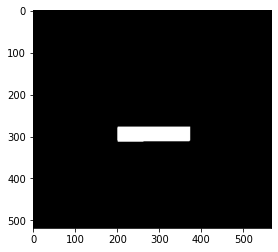

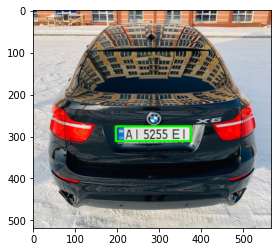

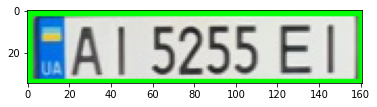

[1.6184431e-04 1.4843087e-04 9.9968958e-01 7.5078809e-08]
['eu_ua_2015']
['AI5255EI']
OK: TEXT:AI5255EI 			 RESULTS:['AI5255EI'] 
					 in PATH:./images/0.jpeg
__________ 		 ./images/1.jpeg 		 __________


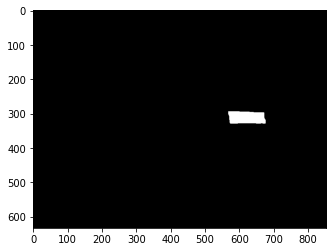

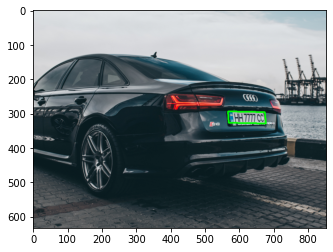

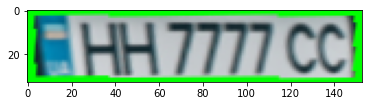

[1.5473431e-04 1.5522559e-04 9.9968994e-01 7.4328362e-08]
['eu_ua_2015']
['AH7777CC']
NOT OK: TEXT:HH7777CC 			 RESULTS:['AH7777CC'] 
					 in PATH:./images/1.jpeg 
__________ 		 ./images/2.jpeg 		 __________


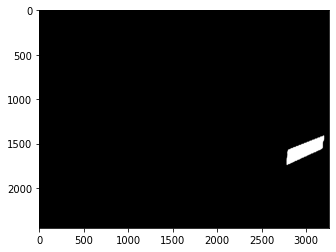

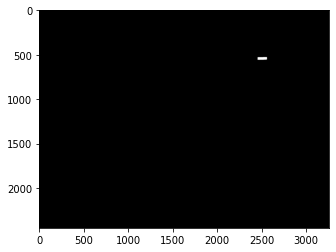

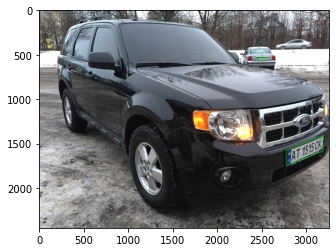

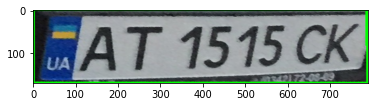

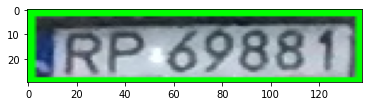

[1.7961612e-04 1.9360293e-04 9.9962664e-01 8.6014275e-08]
[1.4939334e-04 1.5207364e-04 9.9969840e-01 7.4310712e-08]
['eu_ua_2015', 'eu']
['AT1515CK', 'RP69881']
OK: TEXT:AT1515CK 			 RESULTS:['AT1515CK', 'RP69881'] 
					 in PATH:./images/2.jpeg
__________ 		 ./images/3.jpeg 		 __________


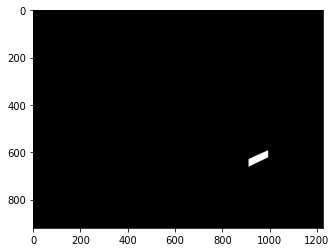

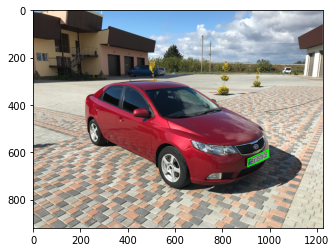

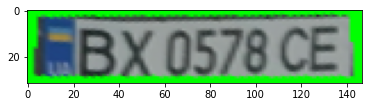

[1.8200057e-04 1.6401552e-04 9.9965382e-01 7.9759893e-08]
['eu_ua_2015']
['BX0578CE']
OK: TEXT:BX0578CE 			 RESULTS:['BX0578CE'] 
					 in PATH:./images/3.jpeg
__________ 		 ./images/4.jpeg 		 __________


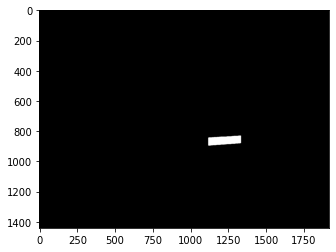

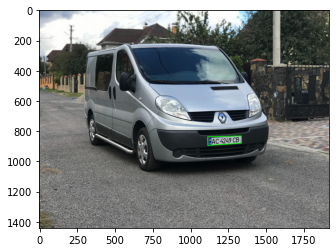

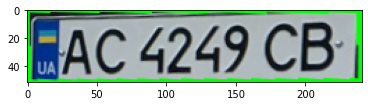

[2.0406678e-04 1.6647346e-04 9.9962938e-01 8.3440497e-08]
['eu_ua_2015']
['AC4249CB']
OK: TEXT:AC4249CB 			 RESULTS:['AC4249CB'] 
					 in PATH:./images/4.jpeg
__________ 		 ./images/5.jpeg 		 __________


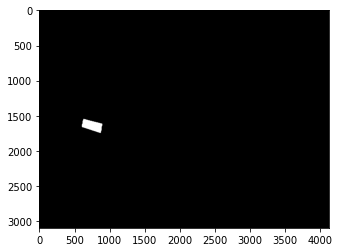

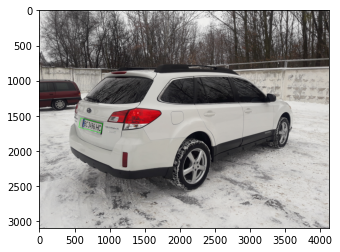

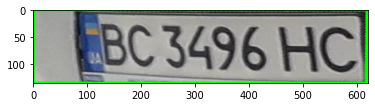

[1.4307549e-04 1.4628723e-04 9.9971050e-01 7.1730391e-08]
['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:./images/5.jpeg
__________ 		 ./images/6.jpeg 		 __________


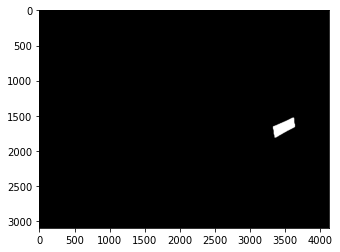

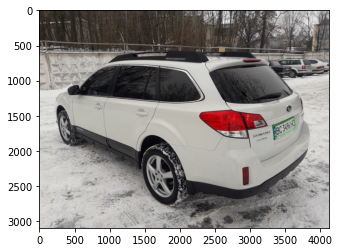

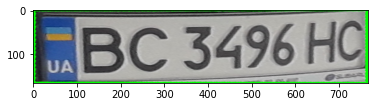

[1.6246665e-04 1.5903430e-04 9.9967837e-01 7.6702428e-08]
['eu_ua_2015']
['BC3496HC']
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:./images/6.jpeg
__________ 		 ./images/7.jpeg 		 __________


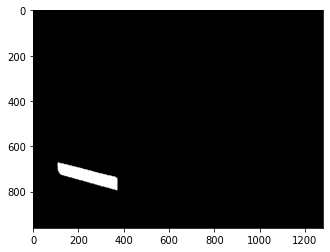

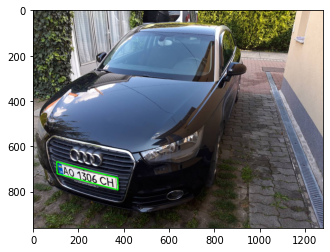

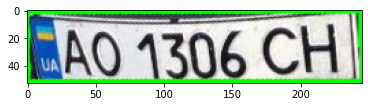

[1.5317451e-04 1.4033556e-04 9.9970633e-01 7.1422782e-08]
['eu_ua_2015']
['AO1306CH']
OK: TEXT:AO1306CH 			 RESULTS:['AO1306CH'] 
					 in PATH:./images/7.jpeg
__________ 		 ./images/8.jpeg 		 __________


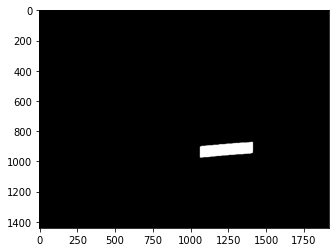

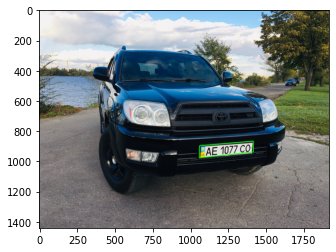

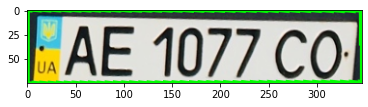

[2.93104764e-04 3.19048238e-04 9.99387741e-01 1.17662395e-07]
['eu_ua_2004']
['AE1077CO']
OK: TEXT:AE1077CO 			 RESULTS:['AE1077CO'] 
					 in PATH:./images/8.jpeg
__________ 		 ./images/9.jpeg 		 __________


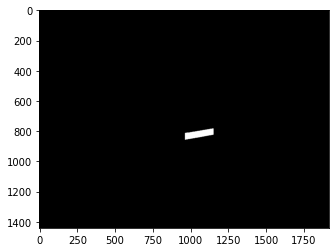

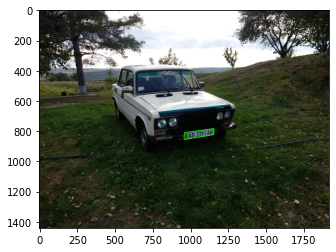

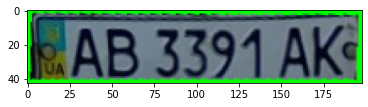

[1.2983207e-04 1.3170142e-04 9.9973840e-01 6.6732120e-08]
['eu_ua_2004']
['AB3391AK']
OK: TEXT:AB3391AK 			 RESULTS:['AB3391AK'] 
					 in PATH:./images/9.jpeg
__________ 		 ./images/10.jpeg 		 __________


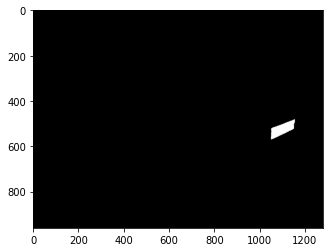

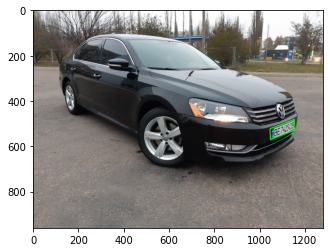

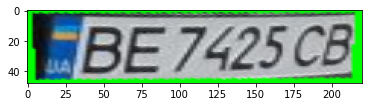

[1.6329963e-04 1.6168243e-04 9.9967492e-01 7.7874390e-08]
['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:./images/10.jpeg
__________ 		 ./images/11.jpeg 		 __________


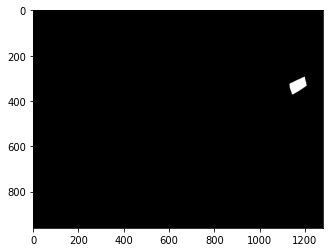

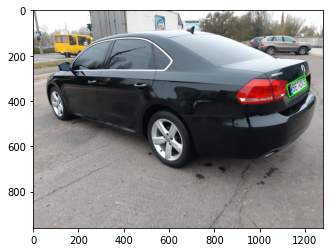

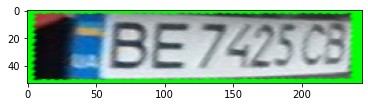

[2.0049045e-04 1.6937821e-04 9.9962997e-01 8.4606924e-08]
['eu_ua_2015']
['BE7425CB']
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:./images/11.jpeg
__________ 		 ./images/12.jpeg 		 __________


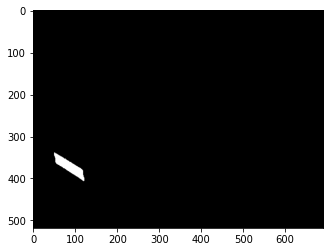

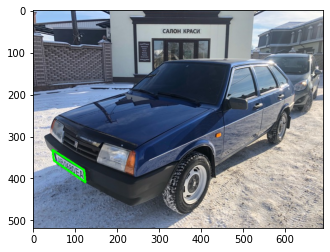

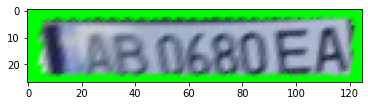

[2.7686899e-04 2.2271268e-04 9.9950027e-01 1.0263538e-07]
['eu_ua_2015']
['AB0680EA']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA'] 
					 in PATH:./images/12.jpeg
__________ 		 ./images/13.jpeg 		 __________


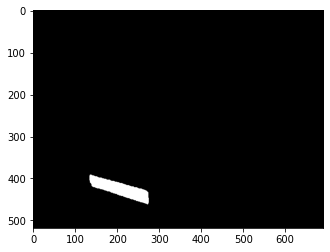

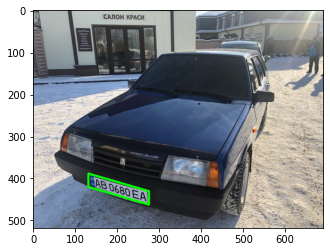

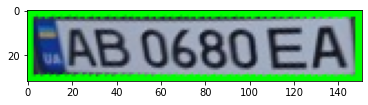

[1.7066630e-04 1.5920826e-04 9.9967003e-01 7.7568323e-08]
['eu_ua_2015']
['AB0680EA']
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA'] 
					 in PATH:./images/13.jpeg
__________ 		 ./images/14.jpeg 		 __________


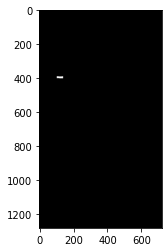

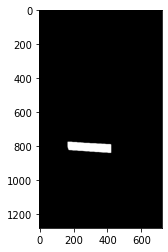

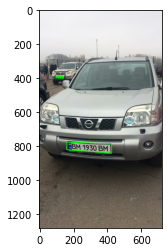

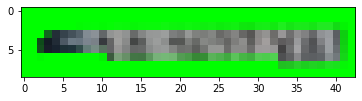

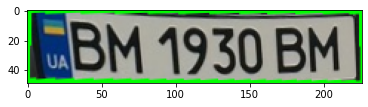

[3.7866512e-01 7.2711646e-03 6.1406064e-01 3.0650015e-06]
[1.5496595e-04 1.5059920e-04 9.9969435e-01 7.4555309e-08]
['xx_unknown', 'eu_ua_2015']
['', 'BM1930BM']
OK: TEXT:BM1930BM 			 RESULTS:['', 'BM1930BM'] 
					 in PATH:./images/14.jpeg
__________ 		 ./images/15.jpeg 		 __________


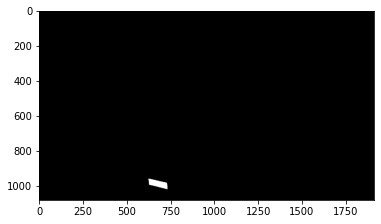

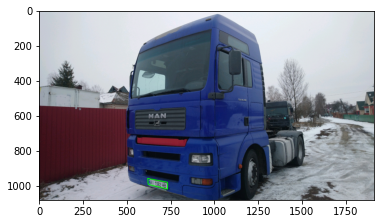

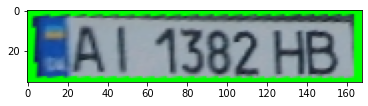

[1.7009562e-04 1.5504305e-04 9.9967480e-01 7.7134054e-08]
['eu_ua_2015']
['AI1382HB']
OK: TEXT:AI1382HB 			 RESULTS:['AI1382HB'] 
					 in PATH:./images/15.jpeg
__________ 		 ./images/16.jpeg 		 __________


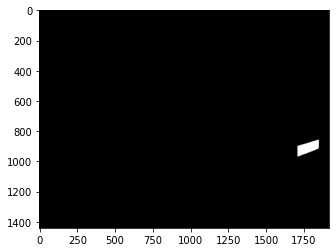

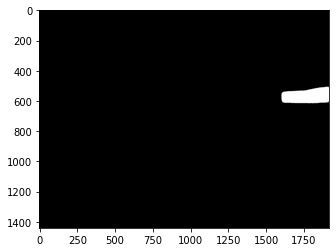

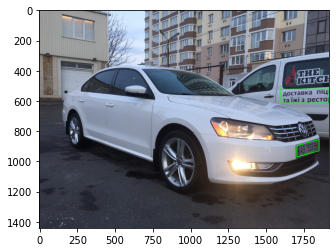

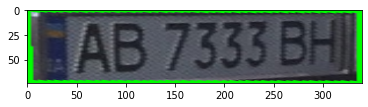

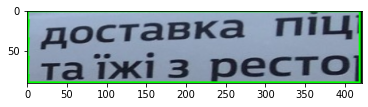

[1.2570068e-04 1.2462033e-04 9.9974960e-01 6.4714385e-08]
[9.9976128e-01 8.6970089e-05 1.5165075e-04 6.4549830e-08]
['eu_ua_2015', 'xx_unknown']
['AB7333BH', '']
OK: TEXT:AB7333BH 			 RESULTS:['AB7333BH', ''] 
					 in PATH:./images/16.jpeg
__________ 		 ./images/17.jpeg 		 __________


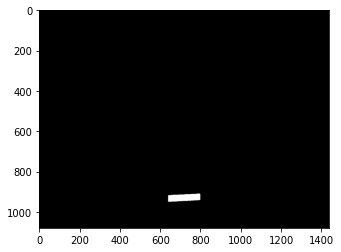

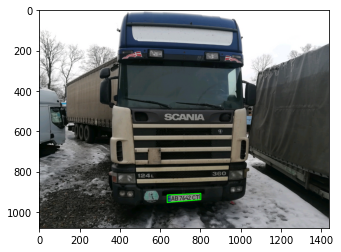

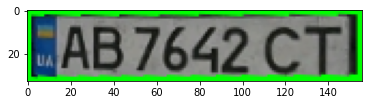

[1.6077548e-04 1.4850298e-04 9.9969065e-01 7.4041459e-08]
['eu_ua_2015']
['AB7642CT']
OK: TEXT:AB7642CT 			 RESULTS:['AB7642CT'] 
					 in PATH:./images/17.jpeg
__________ 		 ./images/18.jpeg 		 __________


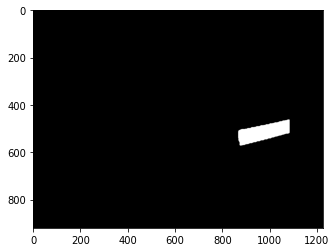

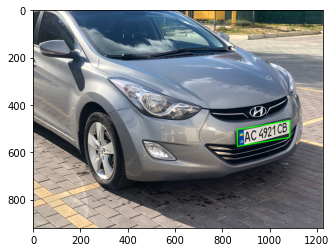

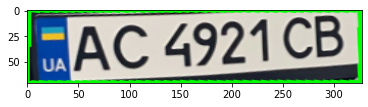

[1.9126854e-04 1.9542956e-04 9.9961323e-01 8.7444313e-08]
['eu_ua_2015']
['AC4921CB']
OK: TEXT:AC4921CB 			 RESULTS:['AC4921CB'] 
					 in PATH:./images/18.jpeg
__________ 		 ./images/19.jpeg 		 __________


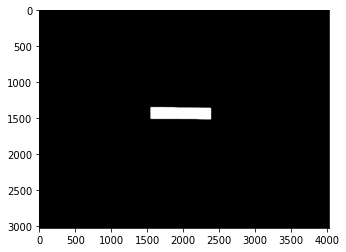

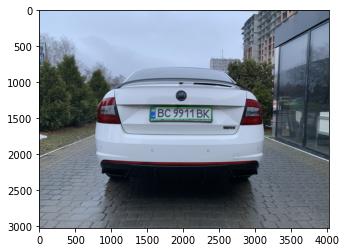

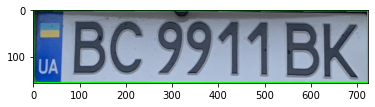

[1.4126387e-04 1.3754307e-04 9.9972111e-01 6.9695226e-08]
['eu_ua_2015']
['BC9911BK']
OK: TEXT:BC9911BK 			 RESULTS:['BC9911BK'] 
					 in PATH:./images/19.jpeg
__________ 		 ./images/20.jpeg 		 __________


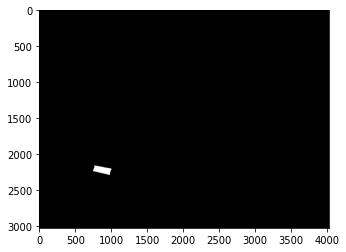

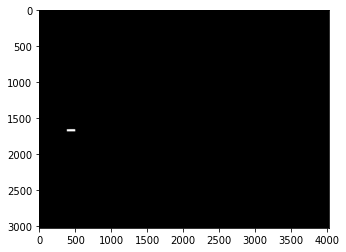

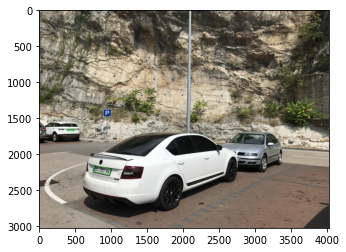

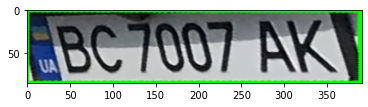

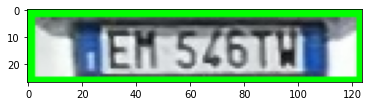

[2.4779627e-04 3.4831351e-04 9.9940372e-01 1.1647591e-07]
[1.090728e-02 1.216882e-03 9.878753e-01 6.185013e-07]
['eu_ua_2015', 'xx_unknown']
['BC7007AK', '']
OK: TEXT:BC7007AK 			 RESULTS:['BC7007AK', ''] 
					 in PATH:./images/20.jpeg
__________ 		 ./images/21.jpeg 		 __________


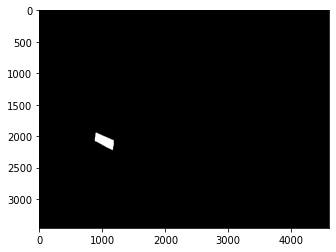

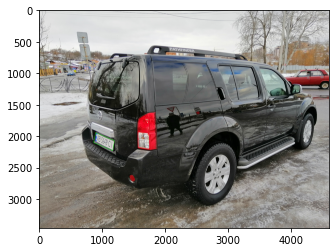

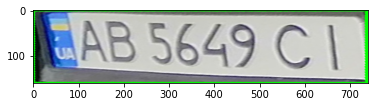

[1.6904291e-04 1.7023164e-04 9.9966061e-01 7.8751548e-08]
['eu_ua_2015']
['AB5649CI']
OK: TEXT:AB5649CI 			 RESULTS:['AB5649CI'] 
					 in PATH:./images/21.jpeg
__________ 		 ./images/22.jpeg 		 __________


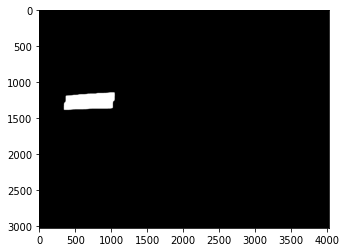

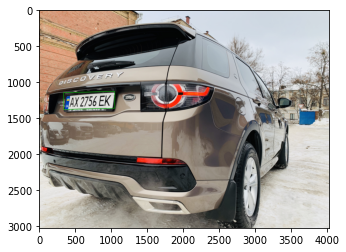

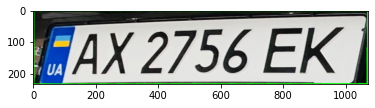

[1.8150674e-04 1.8634414e-04 9.9963200e-01 8.4241726e-08]
['eu_ua_2015']
['AX2756EK']
OK: TEXT:AX2756EK 			 RESULTS:['AX2756EK'] 
					 in PATH:./images/22.jpeg
__________ 		 ./images/23.jpeg 		 __________


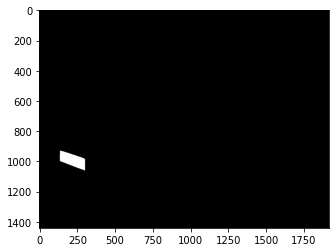

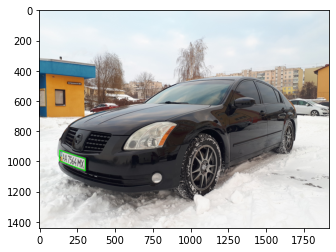

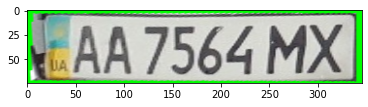

[1.4092006e-04 1.3607318e-04 9.9972290e-01 6.9035551e-08]
['eu_ua_2004']
['AA7564MX']
OK: TEXT:AA7564MX 			 RESULTS:['AA7564MX'] 
					 in PATH:./images/23.jpeg
__________ 		 ./images/24.jpeg 		 __________


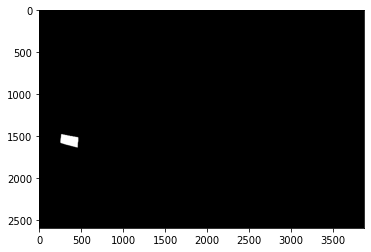

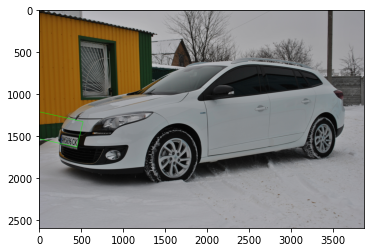

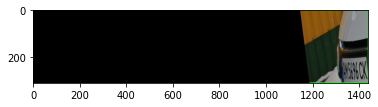

[9.9848700e-01 8.1421610e-04 6.9858885e-04 2.2381921e-07]
['xx_unknown']
['']
NOT OK: TEXT:AM5696CK 			 RESULTS:[''] 
					 in PATH:./images/24.jpeg 
__________ 		 ./images/25.jpeg 		 __________


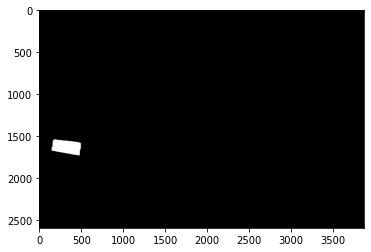

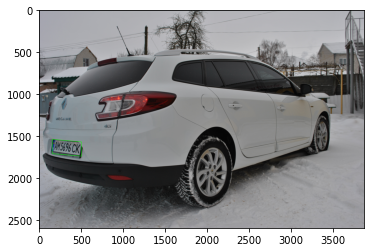

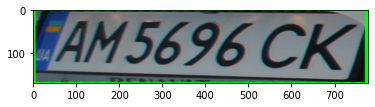

[1.3459970e-04 1.4868737e-04 9.9971658e-01 7.0348257e-08]
['eu_ua_2015']
['AM5696CK']
OK: TEXT:AM5696CK 			 RESULTS:['AM5696CK'] 
					 in PATH:./images/25.jpeg
TOTAL GOOD: 0.9230769230769231
TOTAL BED: 0.07692307692307693


In [7]:
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    nGood, nBad = await test(dirName, fileName, testData[fileName], verbose=1)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")